In [1]:
from IPython.display import Image

### RL settings

Reinforcement Learning algorithms in a nutshell

- Add randomness to your actions
    - exploration
- If the result was better than expected, do more of the same in the future
    - exploitation

In [3]:
Image(url='./imgs/rl_setting.png', width=300)

$$
\mathbb{E} \left[ \sum_{t} r_t \right]
$$
- Formulation: find policy that maximizes expected reward
- In the reinforcement learning formulation, the reward is given by the environment
- In reality, the agent rewards itself

- agent == neural network

In [4]:
Image(url='imgs/agent_as_nn.png', width=300)

### model-free RL: two classes of algos

**Policy gradients:**
- "Just take the gradient"
- Stable, easy to use
- Very few tricks needed
- **On policy**: "I can learn only from my own actions"

$$
\nabla_{\omega} J_{\omega} = \nabla_{\omega} \int \pi(\theta; \omega) R_{\theta} d\theta = \int \nabla_{\omega} \pi(\theta; \omega) R_{\theta} d\theta=\int \pi(\theta; \omega) \nabla_{\omega} \log \pi(\theta; \omega) R_{\theta} d\theta \approx \frac{1}{N} \sum_{i=1}^{N} \nabla_{\omega} \log \pi(\theta_i; \omega) R^{[i]}
$$
- $\theta$：表示 action，$\omega$：表示 nn 的 parameters
- $\nabla f=f\nabla \log f$
- try some actions, 如果其行为正向（$R_\theta\gt 0$），就增加其对应的对数概率 $\log \pi(\theta;\omega)$
---

**Q-learning based:**
- Less stable, more sample efficient
- Won't explain how it works
- **Off policy:** can be trained on data generated by some other policy!
    - 不仅能从 actor 产生的数据中进行学习，还能从其他数据中获取知识；
    - 任何策略生成的 $s_t,a_t,r_{t+1}, s_{t+1}$
- DDPG: a continuous version of Q-learning；

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \lambda \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$


#### Policy Gradient（REINFORCE）

- $a_t\sim\pi_\theta(a_t|s_t)$
- 每个时间步，$R_t=\sum_{k=0}^{T-t}\gamma^kr_{t+k}$
    - 当前 $R_t$ 由未来的 $r_{t}$ 定义（未来的reward 折现）
    - 称为 discounted_rewards
- 计算策略梯度（policy gradient）（在实践中，通过对整个episode的数据进行采样近似。）
    - $\nabla_\theta J(\theta)=\mathbb E_\pi[\nabla_\theta \pi_\theta(a_t|s_t)\cdot R_t]$

In [16]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np   
import matplotlib.pyplot as plt

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        action_probs = self.softmax(self.fc2(x))
        return action_probs

In [36]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

policy_net = PolicyNetwork(state_size, action_size)
optimizer = optim.Adam(policy_net.parameters(), lr=1e-2)

In [37]:
def select_action(state):
    state = torch.from_numpy(state).float()
    action_probs = policy_net(state)
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)

def update_policy(episode_rewards, log_probs):
    discounted_rewards = []
    R = 0
    gamma = 0.99
    
    for r in reversed(episode_rewards):
        R = r + gamma * R
        discounted_rewards.insert(0, R)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
    loss = []
    for log_prob, R in zip(log_probs, discounted_rewards):
        loss.append(-log_prob * R)
    optimizer.zero_grad()
    loss = torch.stack(loss).sum()
    loss.backward()
    optimizer.step()

In [38]:
num_episodes = 300
total_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    episode_rewards = []
    log_probs = []
    done = False

    # 为 done 时，本次 episode 结束
    while not done:
        action, log_prob = select_action(state)
        next_state, reward, done, info = env.step(action)
        episode_rewards.append(reward)
        log_probs.append(log_prob)
        state = next_state
        if done:
            update_policy(episode_rewards, log_probs)
            total_reward = sum(episode_rewards)
            total_rewards.append(total_reward)
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode + 1}, Total Reward: {total_reward}")
            break

Episode 10, Total Reward: 51.0
Episode 20, Total Reward: 35.0
Episode 30, Total Reward: 33.0
Episode 40, Total Reward: 67.0
Episode 50, Total Reward: 28.0
Episode 60, Total Reward: 63.0
Episode 70, Total Reward: 50.0
Episode 80, Total Reward: 49.0
Episode 90, Total Reward: 69.0
Episode 100, Total Reward: 109.0
Episode 110, Total Reward: 185.0
Episode 120, Total Reward: 124.0
Episode 130, Total Reward: 105.0
Episode 140, Total Reward: 100.0
Episode 150, Total Reward: 110.0
Episode 160, Total Reward: 155.0
Episode 170, Total Reward: 500.0
Episode 180, Total Reward: 500.0
Episode 190, Total Reward: 25.0
Episode 200, Total Reward: 39.0
Episode 210, Total Reward: 320.0
Episode 220, Total Reward: 500.0
Episode 230, Total Reward: 500.0
Episode 240, Total Reward: 500.0
Episode 250, Total Reward: 500.0
Episode 260, Total Reward: 500.0
Episode 270, Total Reward: 500.0
Episode 280, Total Reward: 500.0
Episode 290, Total Reward: 500.0
Episode 300, Total Reward: 500.0


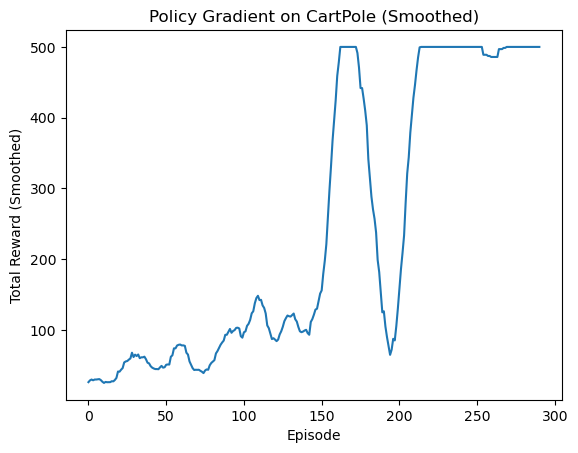

In [39]:
# 定义移动平均函数
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 平滑奖励曲线
window_size = 10
smoothed_rewards = moving_average(total_rewards, window_size)

# 绘制平滑后的奖励曲线
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward (Smoothed)')
plt.title('Policy Gradient on CartPole (Smoothed)')
plt.show()

#### dqn

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \lambda \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$

- 根据 $\epsilon$-greedy 策略选择动作
    - 以概率 $\epsilon$ 随机选择动作
    - 以概率 $1-\epsilon$ 基于 $\arg\max_aQ(s_t,a;\theta)$
- mse loss
    - target q
        - if done: $y_i=r_i$
        - if not done: $y_i=r_i+\gamma_a'Q(s_{i+1},a';\theta)$
        - 统一起来就是 $y_i=r_i+\gamma_a'Q(s_{i+1},a';\theta)(1-\text{done})$
    - $\ell=\frac1N\sum_{i=1}^N(y_i-Q_{\text{current}}(s_i,a_i;'\theta))^2$

In [40]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [46]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        Q_values = self.fc3(x)
        # return logits
        return Q_values

In [42]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

q_net = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

memory = deque(maxlen=10000)
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

In [43]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            Q_values = q_net(state)
        return Q_values.argmax().item()

def replay():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)
    states = torch.tensor(states).float()
    actions = torch.tensor(actions).unsqueeze(1)
    rewards = torch.tensor(rewards).float().unsqueeze(1)
    next_states = torch.tensor(next_states).float()
    dones = torch.tensor(dones).float().unsqueeze(1)
    
    Q_current = q_net(states).gather(1, actions)
    with torch.no_grad():
        Q_next = q_net(next_states).max(1)[0].unsqueeze(1)
    Q_target = rewards + (gamma * Q_next * (1 - dones))
    
    loss = criterion(Q_current, Q_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [44]:
num_episodes = 500
total_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, info = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        replay()
        if done:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
            total_rewards.append(total_reward)
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            break

/tmp/ipykernel_2798549/3351185809.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states).float()


Episode 10, Total Reward: 18.0, Epsilon: 0.95
Episode 20, Total Reward: 21.0, Epsilon: 0.90
Episode 30, Total Reward: 15.0, Epsilon: 0.86
Episode 40, Total Reward: 58.0, Epsilon: 0.82
Episode 50, Total Reward: 38.0, Epsilon: 0.78
Episode 60, Total Reward: 58.0, Epsilon: 0.74
Episode 70, Total Reward: 46.0, Epsilon: 0.70
Episode 80, Total Reward: 58.0, Epsilon: 0.67
Episode 90, Total Reward: 81.0, Epsilon: 0.64
Episode 100, Total Reward: 56.0, Epsilon: 0.61
Episode 110, Total Reward: 163.0, Epsilon: 0.58
Episode 120, Total Reward: 310.0, Epsilon: 0.55
Episode 130, Total Reward: 198.0, Epsilon: 0.52
Episode 140, Total Reward: 61.0, Epsilon: 0.50
Episode 150, Total Reward: 108.0, Epsilon: 0.47
Episode 160, Total Reward: 206.0, Epsilon: 0.45
Episode 170, Total Reward: 189.0, Epsilon: 0.43
Episode 180, Total Reward: 205.0, Epsilon: 0.41
Episode 190, Total Reward: 160.0, Epsilon: 0.39
Episode 200, Total Reward: 29.0, Epsilon: 0.37
Episode 210, Total Reward: 148.0, Epsilon: 0.35
Episode 220, 

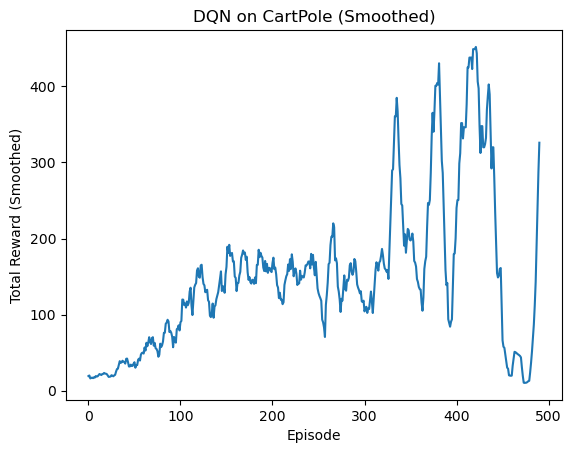

In [45]:
# 定义移动平均函数
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 平滑奖励曲线
window_size = 10
smoothed_rewards = moving_average(total_rewards, window_size)

# 绘制平滑后的奖励曲线
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward (Smoothed)')
plt.title('DQN on CartPole (Smoothed)')
plt.show()

### misc

- Given an environment, must discover correct action
- Random behavior must generate some reward
    - Otherwise learning will not occur!
- If the reward is too sparse, cannot learn

In [47]:
Image(url='./imgs/her_idea.png', width=400)

### self play